In [ ]:
# Nate Brunacini, nbrunaci@u.rochester.edu
# Supervisor: Kelly A. Douglass
# This file includes methods to find the gradient (slope of the trend line) of the 3D (or "R") metallicities of 
# each spaxel in a MaNGA galaxy and to create a scatter plot of those gradient values.

In [13]:
# Import packages
from astropy.io import fits
import deproject_spaxel as dps
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table
from scipy.stats import linregress
from scipy.optimize import curve_fit

import marvin
from marvin.tools.maps import Maps

In [14]:
# Takes in plateifu and table of kinematic center data, returns coordinates of kinematic center of galaxy
def getKinematicCenter(plateifu,c_table):
    plate, ifu = plateifu.split('-')
    bool_index = np.logical_and(c_table['MaNGA_plate'] == int(plate), c_table['MaNGA_IFU'] == int(ifu))
    x_coord = c_table['x0_map'][bool_index].data[0]
    y_coord = c_table['y0_map'][bool_index].data[0]
    return (y_coord,x_coord)
    
# x0_map,y0_map: pass in as (y,x); same as (row,column)

# Returns coordinates of photometric center of the galaxy with the given plateifu
def getPhotometricCenter(plateifu):
    maps = Maps(plateifu)
#     print(maps.datamodel)
    gfluxmap = maps['spx_mflux']
    center = np.unravel_index(np.argmax(gfluxmap.data),gfluxmap.shape)
    return center

In [15]:
# Takes in plateifu, data from drpall file, and table of kinematic centers, generates lists of normalized radius from galactic center and metallicity values, and outputs them in a dictionary
def radius_lists(plateifu,drp,c_table):
    q0 = 0.2
    with fits.open('Pilyugin_'+plateifu+'_DR17_v1.fits', mode='update') as hdul:
        index = np.where(drp['PLATEIFU'] == plateifu)[0][0]# Index of galaxy with the given plateifu; there is only one value but it is nested, hence the [0][0]
        rot_angle = drp['NSA_ELPETRO_PHI'][index] * math.pi/180# Rotation angle; converted from degrees to radians
        #inc_angle = np.arccos(drp['NSA_ELPETRO_BA'][index])#math.pi/2.0 - math.asin(drp['NSA_ELPETRO_BA'][index])# Inclination angle; converted from axis ratio to angle in radians
        
        cosi2 = (drp['NSA_ELPETRO_BA'][index]**2 - q0**2)/(1 - q0**2)
        if cosi2 < 0:
            cosi2 = 0
        inc_angle = np.arccos(np.sqrt(cosi2))
        
        re = drp['NSA_ELPETRO_TH50_R'][index]# 50% light radius in SDSS r-band (in arcsec)
        
        # Get the kinematic center of the galaxy; if there is none in the data file, use photometric center
        center = getKinematicCenter(plateifu,c_table)
        if center == -99.0:# No kinematic center if value is -99
            center = getPhotometricCenter(plateifu)
        
        #Arrays of values to be plotted
        radii_R = ma.array(np.zeros(hdul[1].shape),mask=hdul[3].data)# List of normalized radii between each spaxel and the galactic center for spaxels with R metallicity values
        R = ma.array(hdul[1].data,mask=hdul[3].data)# List of R metallicity values excluding those at masked spaxels
        # Add points to lists
        for row in range(hdul[1].shape[1]):
            for col in range(hdul[1].shape[0]):
                # Calcuate deprojected radius for the spaxel
                coords = (row,col)
                rad_spax,_ = dps.deproject_spaxel(coords,center,rot_angle,inc_angle)#Radius in units of spaxels
                rad_arcsec = rad_spax * 0.5# Radius in arcseconds
#                 rad_normalized = rad_arcsec/re
                radii_R.data[row,col] = rad_arcsec/re
#                 if R.data[row,col] < 8.20 and radii_R[row,col] < 3.0 and radii_R[row,col] > 2.5:#For testing only
#                     print(row,col,radii_R[row,col],R.data[row,col],R.mask[row,col])#For testing only
#     # Add normalized radius and metallicity values to lists if not masked at that spaxel
#                 if not hdul[3].data[row][col]:# Removes masked values
#                     radii_R.append(rad_normalized)
#                     R.append(hdul[1].data[row][col])
    #print(len(radii_R.compressed()))
    return {
            'radii_R': radii_R.compressed(),
            'R': R.compressed(),
            'r50':re
        }

In [41]:
# Linear Model Function. For use by curve_fit in the calculate_fits function
def lmf(x,m,b):
    return m*x+b

In [42]:
# Takes in dictionary of radius and metallicity lists such as that output by the radius_lists function and outputs the parameters of the line of best fit
def calculate_fits(r_lists):
    # Not sure whether the r, p, and se values are needed. There is also an intercept_stderr value but that must be 
    # accessed as an attribute of the returned objected (as in results = linregress(x,y) then results.intercept_stderr)
    #R_params = linregress(r_lists['radii_R'], r_lists['R'])
    R_params = curve_fit(lmf,r_lists['radii_R'], r_lists['R'])[0]
    print(R_params)# For testing
    return {
        # To access individual paramters, use (for example) N2_params.slope, .intercept, .rvalue, .pvalue, .stderr,
        # .intercept_stderr
#         'R_params': R_params,
        'R_params': {'slope': R_params[0], 'intercept':R_params[1]},
        'r50':r_lists['r50']
    }

In [43]:
# Takes in output from radius_lists and calculate_fits functions as well as plateifu and plots scatter plots (metallicity 
# versus normalized radius) with lines of best fit
def scatterplots(r_lists,fit_params,plateifu):
    fig, plots = plt.subplots(1)
    fig.set_figheight(2.5)
    fig.set_figwidth(5)
    plots.plot(r_lists['radii_R'],r_lists['R'],'.')
    plots.set_title('3D Metallicity vs. Normalized Radius')
    plots.set_ylabel('Metallicity')
    plots.set_xlabel('$r / r_e$')
    x_R = np.linspace(min(r_lists['radii_R']),max(r_lists['radii_R']))#(0.0,1.6)
    y_R = fit_params['R_params']['slope'] * x_R + fit_params['R_params']['intercept']
    plots.plot(x_R,y_R,'-r')
    plt.xlim([0,4])
    plt.ylim([8,8.8])
    plt.tight_layout()
    plt.show()
#     plt.savefig('Pilyugin_Galaxy_ScatterPlots/'+plateifu+'ScatterPlot_R')
#     plt.close()

In [44]:
# Wrapper function to call the above functions all at once. Takes in plateifu, data from drpall file, and table of kinematic 
# centers, calculates the parameters of the line of best fit of the normalized radius versus metallicity 
# data, and creates scatter plots
def find_gradient(plateifu,drp,c_table):
    r_lists = radius_lists(plateifu,drp,c_table)
    trend = calculate_fits(r_lists)
    scatterplots(r_lists,trend,plateifu)
    return trend

[-1.34782284e-05  8.43920308e+00]


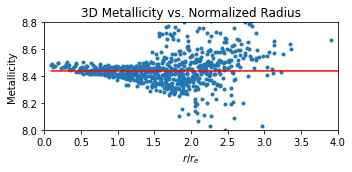

In [45]:
# Calling the functions
with fits.open('drpall-v3_1_1.fits', memmap=True) as drpall:
    c_table = Table.read('DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_noWords_v6.txt',format='ascii.commented_header')
    find_gradient('10001-12701',drpall[1].data,c_table)#('9487-12701',drpall[1].data,c_table)#('8335-12701')#('7443-12705')
#     plt.savefig('PosterMaps/Scatter_8335-12701')
# Test galaxy: 9487-12701

In [8]:
# with fits.open('MetallicityFITS/Brown_7992-12705.fits', mode='update') as hdul:
#     print(hdul.info())

Filename: MetallicityFITS/Brown_7992-12705.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (0,)      
  1  N2_METALLICITY    1 ImageHDU         8   (74, 74)   float64   
  2  O3N2_METALLICITY    1 ImageHDU         8   (74, 74)   float64   
  3  N2O2_METALLICITY    1 ImageHDU         8   (74, 74)   float64   
  4  N2_IVAR       1 ImageHDU         8   (74, 74)   float64   
  5  O3N2_IVAR     1 ImageHDU         8   (74, 74)   float64   
  6  N2O2_IVAR     1 ImageHDU         8   (74, 74)   float64   
  7  N2_MASK       1 ImageHDU         8   (74, 74)   int32   
  8  O3N2_MASK     1 ImageHDU         8   (74, 74)   int32   
  9  N2O2_MASK     1 ImageHDU         8   (74, 74)   int32   
None
